# Pipeline d'imagerie planétaire et astrophysique : empilement, calibration, affinage et couleur

Ce notebook propose un pipeline détaillé et reproductible pour passer de trames alignées et débayérisées à une image astronomique finalisée (principalement planétaire, avec remarques pour ciel profond). Il couvre la calibration instrumentale, la sélection et l'empilement robuste, la restauration (déconvolution / multi‑échelle), et l'amélioration colorimétrique d'images provenant du télescope. Chaque section explique le pourquoi, le comment et les paramètres usuels à surveiller.


## Contexte : planétaire vs ciel profond
- Imagerie planétaire
  - Captures à très courte exposition et haute cadence (video / rafales).
  - Variations rapides de qualité dues à la turbulence; "lucky imaging" (sélection des meilleures trames) est usuel.
  - Traitements typiques : ROI autour de la planète, recalage fin par cross‑correlation/phase, éventuelle dérotation (derotation per‑frame si rotation significative).
- Imagerie ciel profond (courtes poses ou prétraitées)
  - Calibration stricte (bias/dark/flat), enjeux photométriques, poses longues pour SNR.
  - Empilement vise surtout à améliorer sensibilité tout en corrigeant artéfacts cosmiques et pixels chauds.


## Étapes détaillées et recommandations

1. Acquisition et métadonnées
    - Enregistrer exposition, gain, température et timestamps. Pour planétaire, conserver cadence et durée pour gérer dérotation.

2. Calibration instrumentale
   - Bias/dark/flat adaptés aux conditions (température, temps d'expo). Vérifier saturations et linéarité.
   - Pour data planétaire à très courte pose, darks peuvent être moins critiques mais flats restent recommandés si vignettage ou poussières présentes.

3. Dématriçage / débayerisation
   - Choix d'algorithme (bilinéaire, AHD, etc.) selon compromis détails vs bruit. Pour planétaire, débayering minimal permet parfois de préserver davantage de détails.

4. Alignement / registration
   - Méthodes : cross‑correlation, phase correlation (FFT), détecteurs de points+RANSAC si nécessaire.
   - Travailler sur ROI pour accélérer et stabiliser l'algorithme.
   - Si rotation sur la séquence, appliquer derotation avant empilement (ou utiliser algos d'empilement qui supportent rotation).

5. Sélection de trames et scoring
   - Métriques usuelles : variance locale, gradient moyen, FWHM estimé, score sur transformée de Fourier, sharpness metrics.
   - Stratégies : sélection top‑k, top‑fraction, ou pondération continue par score.

6. Empilement (stacking)
   - Méthodes et usage :
     - Moyenne simple : bon SNR si peu d'outliers.
     - Médiane : robuste aux outliers ponctuels.
     - Sigma‑clipping itératif : masque valeurs aberrantes par pixel (bons paramètres : sigma ≈ 2.5–4.0, iters ≈ 3–6).
     - Trimmed mean / Winsorized mean : utile pour distributions biaisées; prévoir fallback (médiane) si nombres faibles.
     - Moyenne pondérée : utiliser scores significatifs; normaliser les poids.
     - Sélection par qualité + empilement : conserve résolution en rejetant trames floues.
   - Gérer masques, canaux couleur et valeurs manquantes; travailler en float pour stabilité.

7. Restauration et amélioration des détails
   - Déconvolution (e.g., Richardson‑Lucy) si PSF estimée; attention aux artefacts et amplifications de bruit.
   - Traitement multi‑échelle (ondelettes, à trous) pour rehausser structures à différentes échelles sans sur‑amplifier le bruit.
   - Unsharp masking sur la luminance (Y de YCrCb) pour éviter artefacts colorés; protéger les zones à faible contraste avec un threshold.

8. Dénoyautage et filtrage
   - Techniques : non‑local means, BM3D, filtre bilatéral adaptatif. Utiliser prudemment : préserver détails fins.
   - Appliquer la réduction de bruit avant ou après déconvolution selon méthode et qualité des données.

9. Correction colorimétrique et tonale
   - Balance des blancs / hue shift pour corriger dominance.
   - Saturation/vibrance (vibrance booste basses saturations sans altérer zones déjà saturées).
   - Contraste / courbes / étirement histogramme (linéaire, log, asinh) selon dynamique de l'objet.
   - Pour mesures photométriques, calibrer sur étoiles de référence.

## Paramètres usuels et heuristiques
- Sigma‑clipping : sigma = 2.5–4.0, max_iters = 3–6.
- Trimmed mean : proportiontocut = 0.05–0.2 selon N.
- Unsharp mask (luminance) : sigma ≈ 1–5 px, amount variable (pour planétaire on peut aller plus haut), threshold > 0 pour images bruitées.
- Vibrance : facteur ≈ 1.0–1.5; saturation : ≈ 1.0–1.5.
- Pour N faible, privilégier médiane ou pondération prudente; trimming agressif nécessite N élevé.
-

## Références Utiles
1. Richardson, W. H. (1972). Bayesian‑based iterative method of image restoration. Journal of the Optical Society of America.
2. Lucy, L. B. (1974). An iterative technique for the rectification of observed distributions. Astronomical Journal.
3. Howell, S. B. (2006). Handbook of CCD Astronomy. Cambridge University Press.
4. Lupton, R., et al. (2004). Preparing RGB Images from CCD Data. PASP/ArXiv.
5. Starck, J.‑L., Murtagh, F., & Bijaoui, A. (1998). Image processing and data analysis: the multiscale approach. Cambridge University Press.


In [1]:
# @title
!git clone --quiet https://github.com/GabrielMissael/super-resolution-workshop

In [3]:
planet = "jupiter" # @param ["jupiter", "saturn"] {'type': 'string'}

import sys
sys.path.append("super-resolution-workshop")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from ipywidgets import interact, FloatSlider, IntSlider

from src.enhance import unsharp_mask_color, denoise_color, adjust_saturation, adjust_contrast_brightness
from src.debayer import debayer_stack
from src.trim_jupiter_images import get_frames
from src.quality_and_align import compute_quality_scores, choose_reference_frame, detect_ref_points, align_frames
from src.visualize_results import overlay_points
from src.stacking import stack_by_quality

if planet == "jupiter":
    data = get_frames("super-resolution-workshop/data/jupiter_frames.avi")
else:
    data = get_frames("super-resolution-workshop/data/mars_frames.avi")
print(f"Data loaded successfully! Data contains {len(data)} images.")

Data loaded successfully!


In [ ]:
# @title
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(data[0], cmap="gray")
ax.axis("off")
plt.tight_layout()


def animate(i):
    im.set_data(data[i])
    return [im]


ani = animation.FuncAnimation(fig, animate, frames=60,
                              interval=1000.0 / 30, blit=True)
html_video = HTML(ani.to_html5_video())
plt.close(fig)
html_video

# Motifs Bayer (CFA) — explication, origine, artefacts et recommandations pour l'astrophotographie

## Qu'est‑ce qu'un motif Bayer ?
Un motif Bayer (Color Filter Array, CFA) est une mosaïque de filtres colorés placée au‑dessus des photosites d'un capteur CMOS/CCD. Chaque photosite mesure une seule composante de couleur; la grille 2×2 la plus courante contient deux verts, un rouge et un bleu. Exemples typiques : `RGGB`, `BGGR`, `GRBG`, `GBRG`. Le signal brut d'un capteur muni d'un CFA est donc une image monochrome où la couleur est échantillonnée spatialement selon la disposition du filtre.


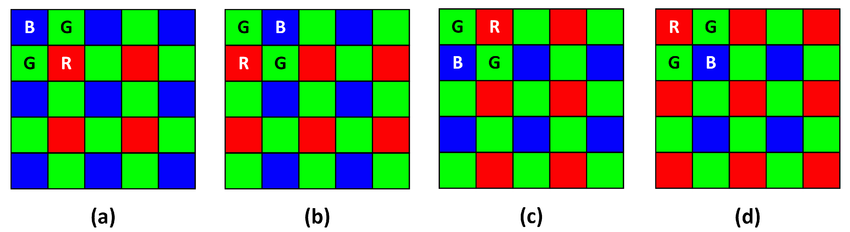

## Pourquoi utiliser une CFA ?
- Les photodiodes de capteurs ne différencient pas les couleurs : la solution pratique est de placer des filtres colorés miniatures devant chaque photosite.
- Le motif Bayer favorise le vert (deux verts par bloc 2×2) car l'œil humain et l'information de luminance sont plus sensibles au vert. Cela améliore la résolution apparente et le rapport signal‑sur‑bruit de la luminance.

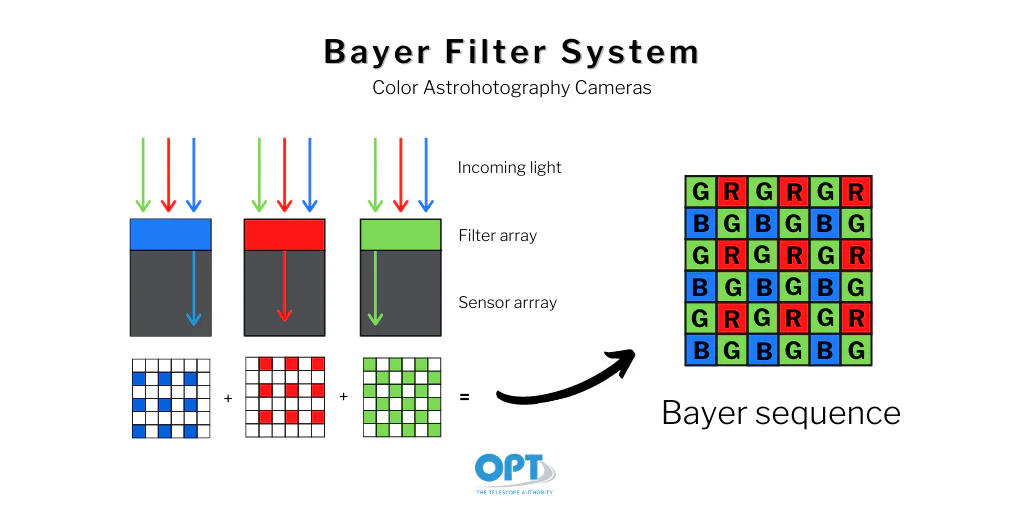


## Comment on obtient une image couleur (dématriçage / démasquage)
Le dématriçage (demosaicing) reconstruit les deux composantes manquantes à chaque pixel en interpolant à partir des échantillons voisins. Méthodes courantes :
- Bilinéaire : rapide, basique, artefacts importants aux bords.
- Malvar‑He‑Cutler (2004) : filtre linéaire optimisé, bon compromis.
- AHD (Adaptive Homogeneity‑Directed) : suit les bords pour réduire zippering/fausses couleurs.
- VNG (Variable Number of Gradients) : méthode basée sur les gradients locaux. VNG calcule des gradients directionnels sur un voisinage et choisit l'orientation d'interpolation qui minimise les variations chromatiques longitudinales, ce qui aide à préserver les bords sans propager les fausses couleurs. VNG est robuste sur textures fines et présente un bon compromis entre préservation d'edge et suppression d'artefacts.

- Méthodes modernes par apprentissage profond : meilleures performances mais coût calcul élevé.
Important : conserver la linéarité (pas de gamma / non‑linéarités) pendant calibrations et dématriçage si on vise une bonne conservation photométrique.

## Artefacts courants et causes
- Zippering / fausses couleurs le long des bords : interpolation inadaptée au long d'un contour.
- Moiré et aliasing : scènes avec détails plus fins que le pas d'échantillonnage CFA (souvent amortis par un filtre optique anti‑aliasing).
- Perte de résolution chromatique : chaque canal couleur est sous‑échantillonné spatialement.
- Amplification du bruit : interpolation et post‑traitement peuvent augmenter le bruit visible.

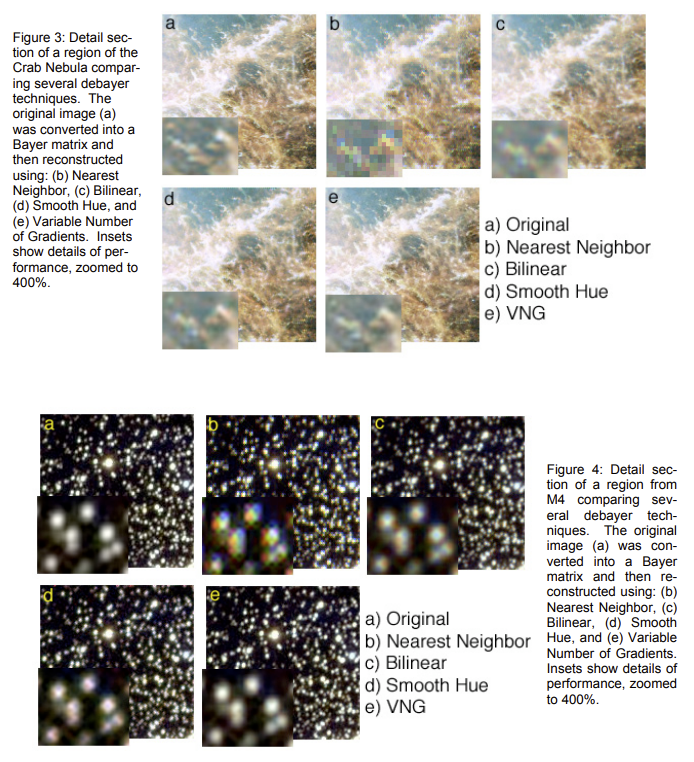

## Variantes de CFA et alternatives
- X‑Trans (Fujifilm) : motif non périodique plus grand pour réduire moiré sans filtre optique.
- Quad‑Bayer / Dual‑ISO : groupements 2×2 pour binning/HDR ou réduction de bruit.
- Capteurs monochromes : absence de CFA pour pleine résolution luminance (utilisés en applications scientifiques/planétaires).

## Considérations pratiques en astrophotographie
- Planétaire (haute cadence) :
  - Souvent préférable de retarder le dématriçage jusqu'après empilement, ou d'empiler par canal ou sur un proxy de luminance (ex. moyenne des verts) pour préserver détails.
  - La sélection d'images (lucky imaging) et la dérivation peuvent être faites sur une image luminance extraite du mosaic RAW.
- Ciel profond (poses longues) :
  - Calibration (bias/dark/flat) en données RAW linéaires avant dématriçage est la pratique recommandée pour préserver linéarité photométrique.
- Balance des blancs et corrections colorimétriques sont généralement réalisées après dématriçage, mais garder la traçabilité des niveaux noirs et gains est crucial pour mesures photométriques.

## Références utiles
- Bayer, B. E. (1976). Patent: Color imaging array.
- Malvar, H. S., He, L., & Cutler, R. (2004). High‑quality linear interpolation for demosaicing.

In [ ]:
pattern = "GRBG" #@param ['RGGB', 'GRBG', 'GBRG', 'BGGR'] {'type':'string'}
method = "VNG" #@param ['VNG', 'Bilinear', 'EA'] {'type':'string'}


deb_frames = debayer_stack(data, pattern=pattern, method=method)
plt.imshow(deb_frames[0])
plt.axis("off")
plt.show()

In [ ]:
# @title
# scores, _, _ = compute_quality_scores(deb_frames)
scores = np.load("super-resolution-workshop/data/scores.npz")["arr_0"]

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(scores, '-k')
ax.set_xlabel('frame')
ax.set_ylabel('quality (normalized)')
ax.set_title('Per-frame quality scores')
ax.grid(alpha=0.3)
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(np.sort(scores)[::-1], '-k')
ax.set_xlabel('frame')
ax.set_ylabel('quality (normalized)')
ax.set_title('Sorted per-frame quality scores')
ax.grid(alpha=0.3)
fig.tight_layout()
plt.show()

In [ ]:
num_images = 5 # @param {'type':'integer'}
N = num_images

sorted_indices = np.argsort(scores)
worst_indices = sorted_indices[:N]
best_indices = sorted_indices[-N:][::-1]

fig, axs = plt.subplots(2, N, figsize=(3 * N, 6.75))

for i in range(N):
    idx = best_indices[i]
    axs[0, i].imshow(deb_frames[idx])
    axs[0, i].set_title(f"Best {i + 1}\nIdx: {idx}\nScore: {scores[idx]:.3f}")
    axs[0, i].axis('off')

    idx = worst_indices[i]
    axs[1, i].imshow(deb_frames[idx])
    axs[1, i].set_title(f"Worst {i + 1}\nIdx: {idx}\nScore: {scores[idx]:.3f}")
    axs[1, i].axis('off')

plt.suptitle("Top: Best Frames (High Score)\nBottom: Worst Frames (Low Score)")
plt.tight_layout()
plt.show()

In [ ]:
reference_idx = choose_reference_frame(scores)
reference_frame = deb_frames[reference_idx]

n_ref_points = 100
ref_pts = detect_ref_points(reference_frame, max_corners=n_ref_points)

image = overlay_points(reference_frame, ref_pts, (1, 0, 0), alpha=0.3)
plt.imshow(image)
plt.show()

In [ ]:
stacking_methods = ["weighted", "average", "median", "sigma", "sigma", "winsorized"]
stacking_method = "ALL" # @param ["weighted","average","median","sigma","winsorized","ALL"] {"allow-input":true}
num_to_stack = 200 #@param {'type': 'integer'}

if stacking_method == "ALL":
    stacking_methods = stacking_methods
else:
    if "," in stacking_method:
        stacking_methods = [method.strip() for method in stacking_method.split(",")]
    else:
        stacking_methods = [stacking_method]

print(f"Stacking methods: {stacking_methods}")

idx_to_align = sorted_indices[-num_to_stack:][::-1]
reference_idx = 0

aligned, transforms = align_frames(deb_frames[idx_to_align], reference_idx, ref_pts)

stacks = []
for method in stacking_methods:
    stack = stack_by_quality(aligned, scores=scores[idx_to_align], method=method)
    stacks.append(stack)
stacked = np.stack(stacks).astype(np.uint8)

n = stacked.shape[0]

fig, axs = plt.subplots(1, n, figsize=(4 * n, 4))
for i in range(n):
    axs[i].imshow(stacked[i])
    axs[i].set_title(f"{stacking_methods[i].capitalize()}")
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
result = {'unsharp': None}

unsharp_mask_color_vmap = np.vectorize(unsharp_mask_color, signature='(n,m,3),(),(),() -> (n,m,3)')

def adjust_unsharp(sigma=2.0, amount=1.0, threshold=0):
    out = unsharp_mask_color_vmap(stacked, sigma=sigma, amount=amount, threshold=threshold)
    result['unsharp'] = out
    fig, axs = plt.subplots(1, n, figsize=(4 * n, 4))
    for i in range(n):
        axs[i].imshow(out[i])
        axs[i].set_title(f"{stacking_methods[i].capitalize()}")
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

interact(
    adjust_unsharp,
    sigma=FloatSlider(value=2.0, min=0.1, max=20.0, step=0.1),
    amount=FloatSlider(value=1.0, min=0.0, max=10.0, step=0.1),
    threshold=IntSlider(value=0, min=0, max=10, step=1)
)

In [ ]:
denoise_color_vmap = np.vectorize(denoise_color, signature='(n,m,3),(),() -> (n,m,3)')

def adjust_denoise(h=0, hColor=0):
    out = denoise_color_vmap(result["unsharp"], h=h, hColor=hColor)
    result['denoised'] = out
    fig, axs = plt.subplots(1, n, figsize=(4 * n, 4))
    for i in range(n):
        axs[i].imshow(out[i])
        axs[i].set_title(f"{stacking_methods[i].capitalize()}")
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

interact(
    adjust_denoise,
    h=FloatSlider(value=0.0, min=0.0, max=5.0, step=0.05),
    hColor=FloatSlider(value=0.0, min=0.0, max=50.0, step=0.05),
)

In [ ]:
adjust_saturation_vmap = np.vectorize(adjust_saturation, signature='(n,m,3),() -> (n,m,3)')
adjust_contrast_brightness_vmap = np.vectorize(adjust_contrast_brightness, signature='(n,m,3),(),() -> (n,m,3)')

def adjust_saturation_plot(factor=1.0, contrast=1.0, brightness=1.0):
    out = adjust_saturation_vmap(result["denoised"], factor=factor)
    out = adjust_contrast_brightness(out, contrast=contrast, brightness=brightness)
    result['saturation'] = out
    fig, axs = plt.subplots(1, n, figsize=(4 * n, 4))
    for i in range(n):
        axs[i].imshow(out[i])
        axs[i].set_title(f"{stacking_methods[i].capitalize()}")
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

interact(
    adjust_saturation_plot,
    factor=FloatSlider(value=1.0, min=0.1, max=3.0, step=0.05),
    contrast=FloatSlider(value=1.0, min=0.1, max=2.0, step=0.02),
    brightness=FloatSlider(value=0.0, min=-100, max=100, step=0.5),
)

In [ ]:
plt.imshow(data[6854], cmap="gray")
plt.axis("off")
plt.show()